# Bootstrap


In [30]:
import numpy as np
#import os
#os.getcwd() 
from base import EnsembleNetwork
import dataset_creation 
import importlib
importlib.reload(dataset_creation)

#import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [15, 5]

%matplotlib inline

In [31]:
ld = dataset_creation.LinearDataset()

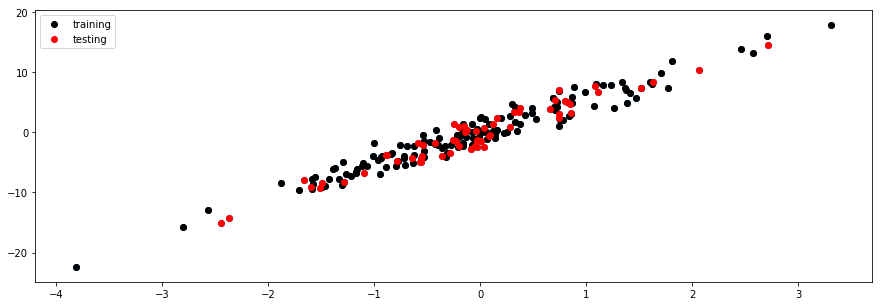

In [32]:
ld.plot_dataset()

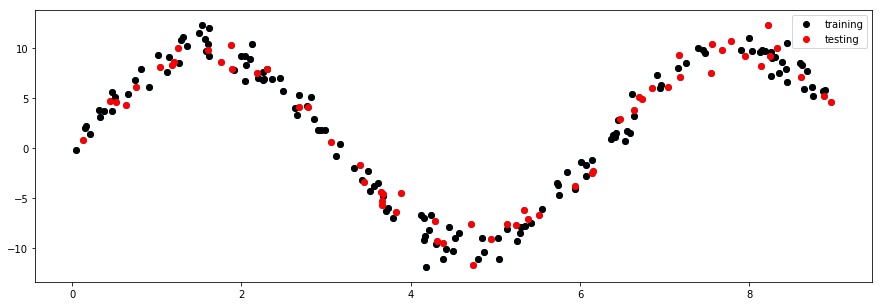

In [33]:
nd = dataset_creation.NonlinearDataset()
nd.plot_dataset()



# Bootstrap Through Time

In [64]:
import matplotlib.pyplot as plt
import numpy as np

class BootstrapEnsemble(object):    
    def __init__(self,ensemble=None,num_features = None,num_epochs=10,num_ensembles=14):
        self.num_features = num_features or 1
        self.ensemble_list = ensemble or [EnsembleNetwork] *num_ensembles
        self.num_epochs = num_epochs
        self.initialise_ensemble()
        
    def initialise_ensemble(self):
        self.ensemble = [member(num_features=self.num_features,seed=i+42,num_epochs=self.num_epochs) for i,member in enumerate(self.ensemble_list)]
        
    def fit(self, X, y):
        '''This is where we build in the Online Bootstrap'''
        for estimator in self.ensemble:
            estimator.fit(X,y)
            
    def get_prediction_list(self,X):
        pred_list = []
        for estimator in self.ensemble:
            prediction = estimator.predict(X)
            pred_list.append(prediction)
        return pred_list
      

    def predict(self, X):
        pred_list = self.get_prediction_list(X)
        predictive_mean = np.mean(pred_list, 0)

        return predictive_mean
    
    def predict_std(self,X):

        pred_list = self.get_prediction_list(X)
        predictive_uncertainty = np.std(pred_list, 0) or 0.001
        

        return predictive_uncertainty
    
    def get_mean_and_std(self,X):
        pred_list = self.get_prediction_list(X)
        pred_mean = np.mean(pred_list,axis=0)
        pred_std = np.std(pred_list,axis=0)
        return pred_mean, pred_std
    

    def compute_rsme(self,X,y):
        y_hat = self.predict(X)
        return np.sqrt(np.mean((y_hat - y)**2))

    
class BootstrapThroughTimeBobStrap_doesntworkbecausetensorflowhasnocopymanthatssad(BootstrapEnsemble):
    
    def __init__(self,num_features = None,num_epochs = 10,num_ensembles=10):
        
        super(BootstrapThroughTimeBobStrap, self).__init__(ensemble=None,num_features = num_features,num_epochs=50,num_ensembles=1)
        self.num_epochs = num_epochs
        self.num_ensembles = num_ensembles
            
            
    @property
    def num_current_ensembles(self):
        return len(self.ensemble)
            
    def fit(self,X,y):
        error_list_self = []
        error_list_model = []
        #replace a member if it's rsme is higher than the new model. Keep new model somewhere and STILL train it, just in case it gets significantly better
        for i in range(self.num_epochs):
            for estimator in self.ensemble:
                if self.num_current_ensembles < self.num_ensembles:
                    self.ensemble.append(copy(estimator))
                    print('{} out of {} predictors ready'.format(self.num_current_ensembles,self.num_ensembles))
                    #replace the worst model with a new one
                estimator.fit(X,y)
            error_list_model.append(estimator.compute_rsme(X,y))
            error_list_self.append(self.compute_rsme(X,y))
            print(np.mean((np.array(error_list_model)-np.array(error_list_self))**2))
            

            
            
class BootstrapThroughTimeBobStrap_doesntworkbecausetensorflowhasnocopymanthatssad(BootstrapEnsemble):
    
    def __init__(self,num_features = None,num_epochs = 10,num_ensembles=10):
        
        super(BootstrapThroughTimeBobStrap, self).__init__(ensemble=None,num_features = num_features,num_epochs=50,num_ensembles=1,seed=None)
        self.num_epochs = num_epochs
        self.num_ensembles = num_ensembles
        self.seed = seed or 42
            
    def initialise_ensemble(self):
        self.ensemble = [member(num_features=self.num_features,seed=self.seed,num_epochs=self.num_epochs) for i,member in enumerate(self.ensemble_list)]
                    
    @property
    def num_current_ensembles(self):
        return len(self.ensemble)
            
    def fit(self,X,y):
        error_list_self = []
        error_list_model = []
        #replace a member if it's rsme is higher than the new model. Keep new model somewhere and STILL train it, just in case it gets significantly better
        for i in range(self.num_epochs):
            for estimator in self.ensemble:
                if self.num_current_ensembles < self.num_ensembles:
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    #self.ensemble.append(copy(estimator))
                    print('{} out of {} predictors ready'.format(self.num_current_ensembles,self.num_ensembles))
                    #replace the worst model with a new one
                estimator.fit(X,y)
            error_list_model.append(estimator.compute_rsme(X,y))
            error_list_self.append(self.compute_rsme(X,y))
            print(np.mean((np.array(error_list_model)-np.array(error_list_self))**2))
            
            
            
            
            
      
from networks import CopyNetwork

class BootstrapThroughTimeBobStrap(BootstrapEnsemble):
    #TODO: decide if replace every epoch or meta-epoch
    
    def __init__(self,num_features = None,num_epochs = 3,num_models=5,model_name='copynetwork'):
        self.model_name = model_name
        self.model = CopyNetwork()
        self.train_iteration = 0

        super(BootstrapThroughTimeBobStrap, self).__init__(ensemble=None,num_features = num_features,num_epochs=50,num_ensembles=1)
        self.num_epochs = num_epochs
        self.num_models = num_models
            
    def initialise_ensemble(self):
        """create list of checkpoint ensembles"""
        name = self.model_name+'checkpoint_' + str(self.train_iteration)
        self.model.save(name)
        self.checkpoints = [name]

    def get_prediction_list(self,X):
        prediction_list = []
        for ckpt in self.checkpoints:
            self.model.load(ckpt)
            prediction_list.append(self.model.predict(X))
            
        return prediction_list

    def fit(self,X,y):
        """trains the most recent model in checkpoint list and replaces the oldest checkpoint if enough checkpoints exist"""
        for i in range(self.num_epochs):
            self.train_iteration +=1
            name = self.model_name+'_checkpoint_'+str(self.train_iteration)

            self.model.load(self.checkpoints[-1]) #load most recent model
            self.model.fit(X,y) #train most recent model
            self.model.save(name) #save newest model as checkpoint
            self.checkpoints.append(name)#add newest checkpoint

            if len(self.checkpoints) > self.num_models: #if we reached max number of stored models
                self.checkpoints.pop(0) #delete oldest checkpoint

        


            

# Bootstrap

In [65]:
#boot = BootstrapEnsemble()

# Bootstrap Through time

In [66]:
bob = BootstrapThroughTimeBobStrap()

In [67]:
#bob.initialise_ensemble()

In [68]:
import visualisation 
importlib.reload(visualisation)

<module 'visualisation' from '/Users/thomas/Documents/Master-Thesis/new_version/visualisation.py'>

INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_1
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_1
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_4
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_5
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_4
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_

'this run of 3 epochs and 6 metaepochs took 29.57133388519287s'

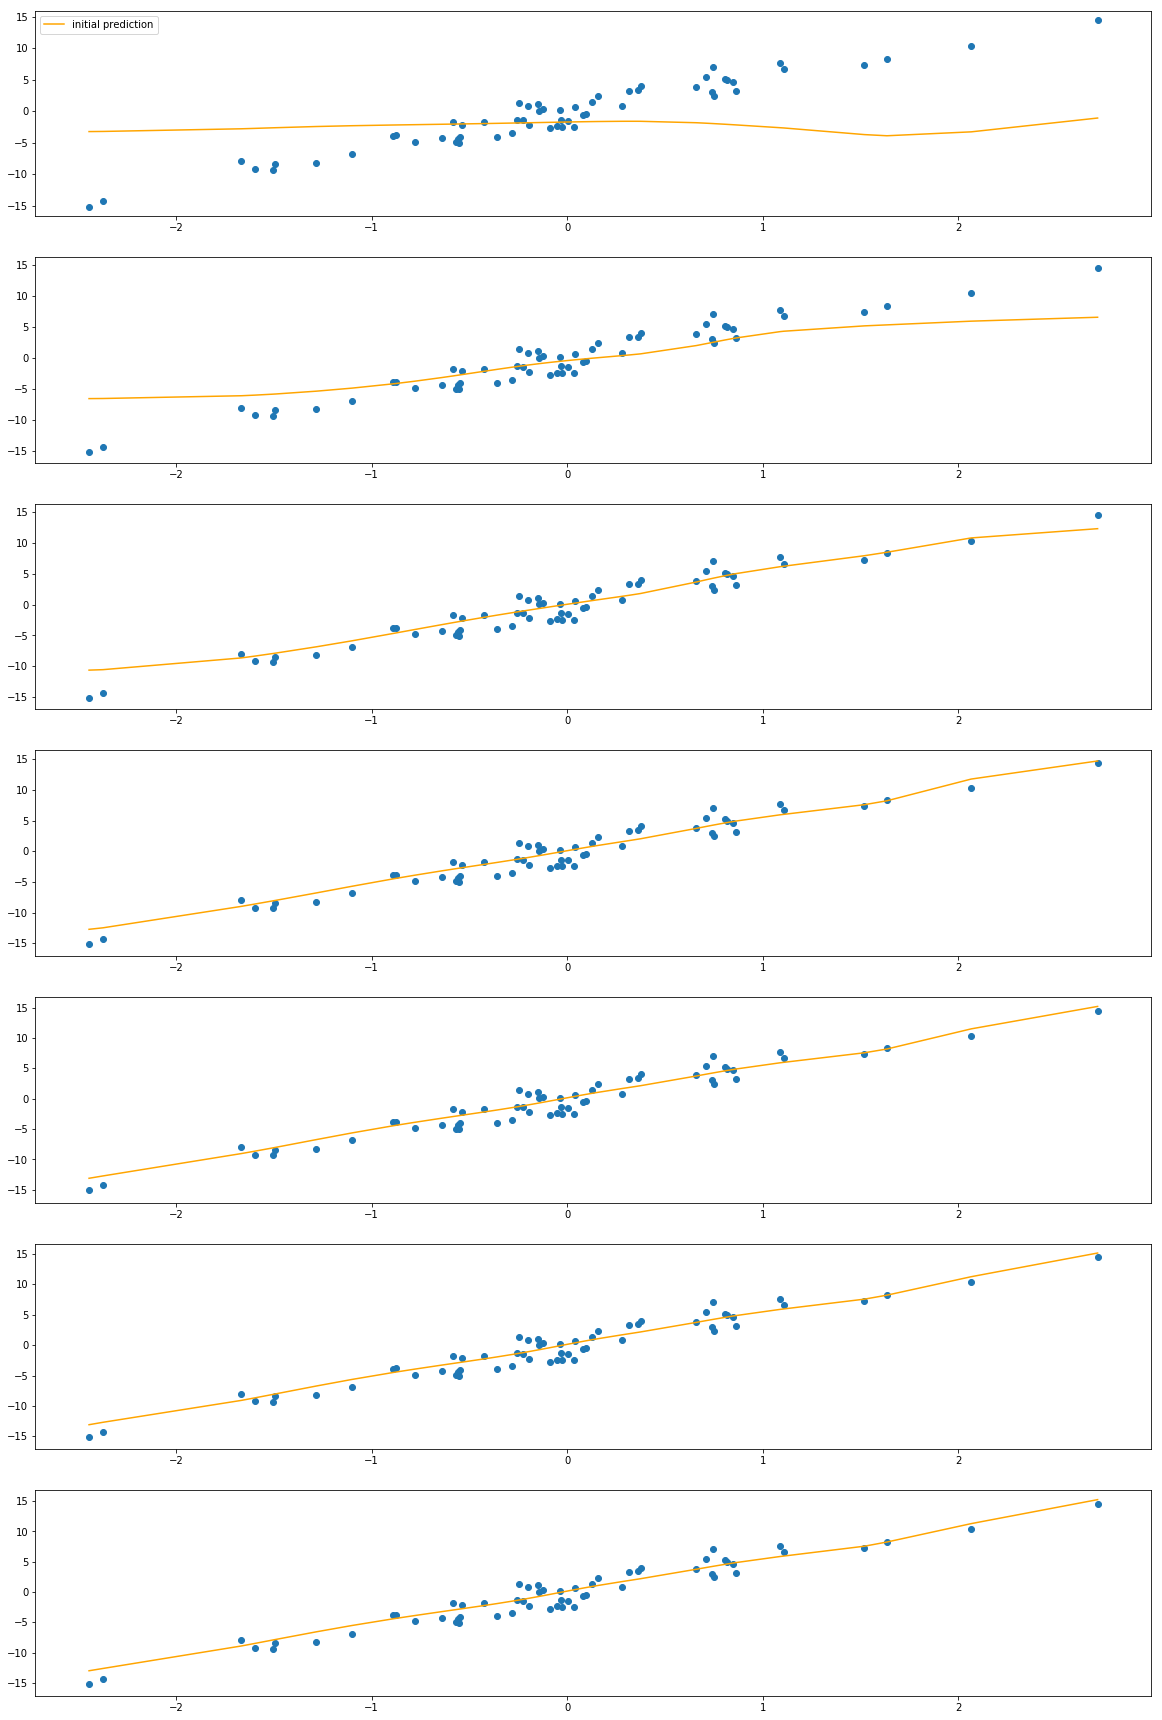

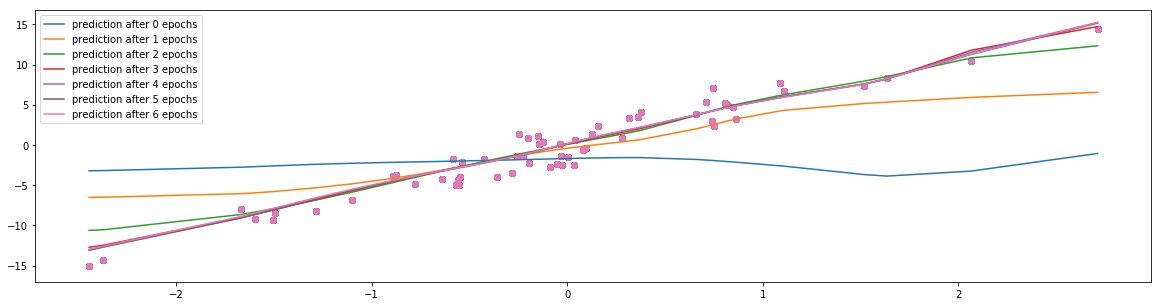

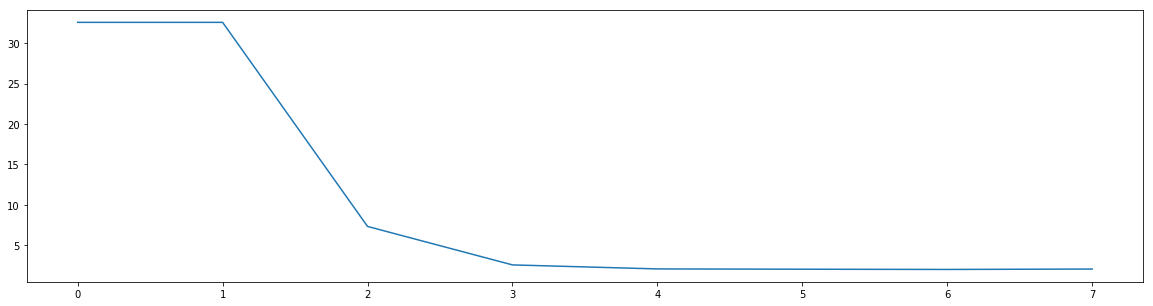

In [69]:
#net = EnsembleNetwork(num_epochs=25)#num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualisation.visualise(bob,dataset_creation.LinearDataset,num_meta_epochs=6)

INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_1
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_1
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_4
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_5
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_4
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_

'this run of 3 epochs and 3 metaepochs took 15.344006061553955s'

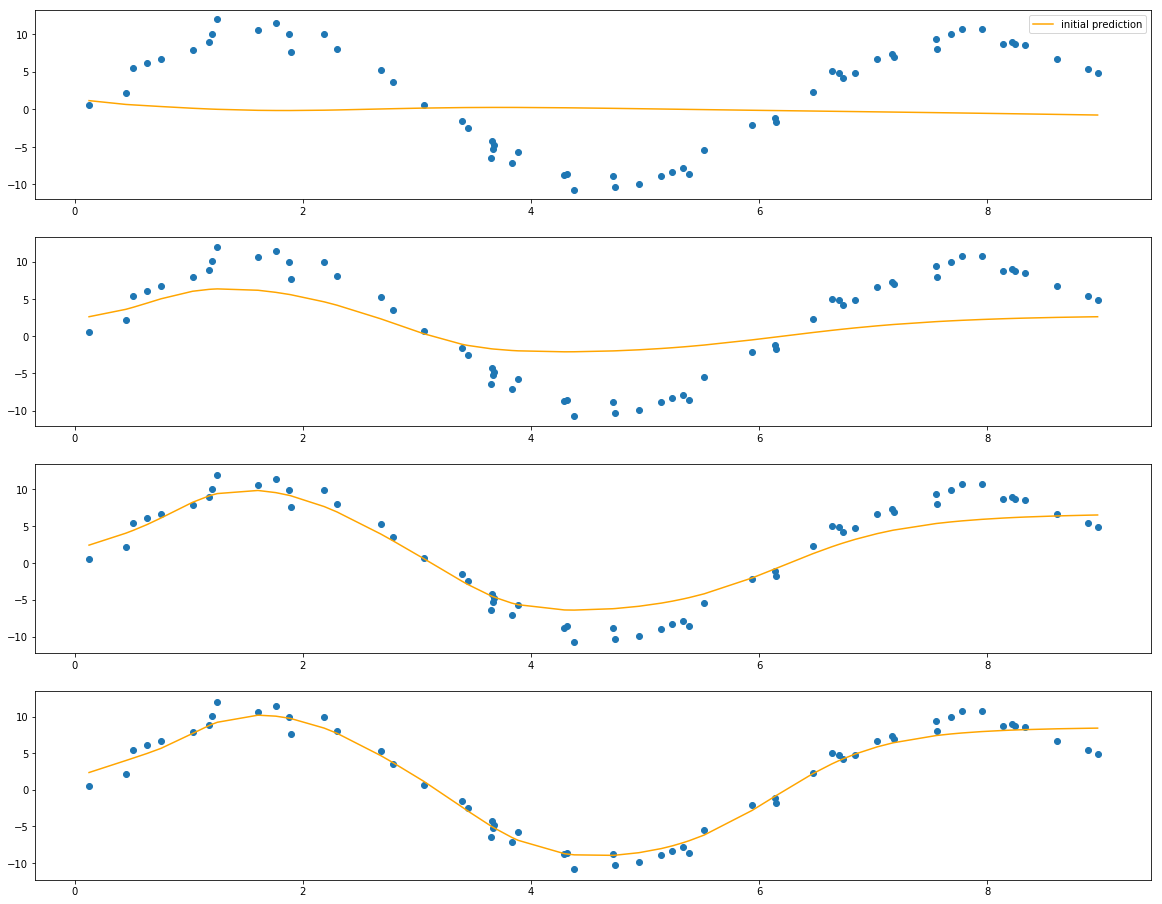

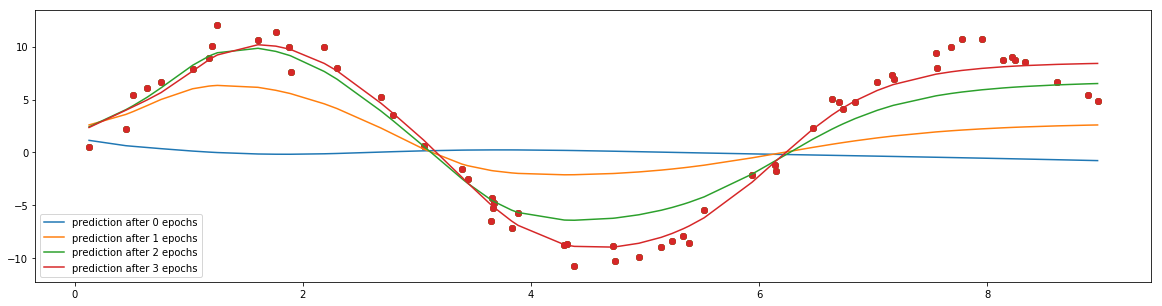

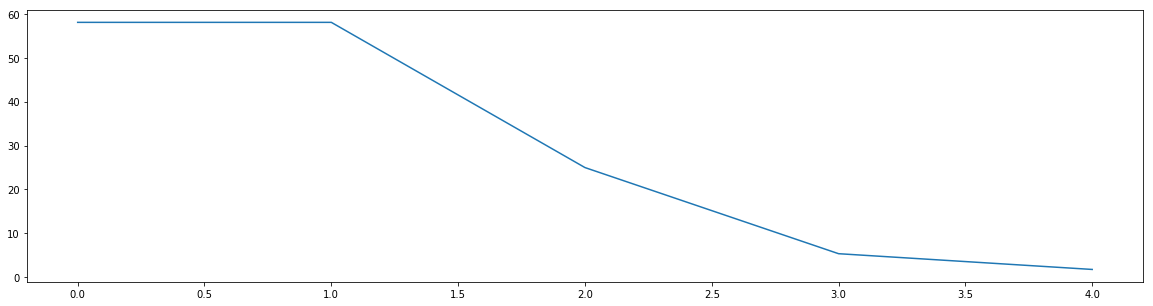

In [70]:
bill = BootstrapThroughTimeBobStrap()
visualisation.visualise(bill,dataset_creation.NonlinearDataset)

In [71]:
import visualisation 
importlib.reload(visualisation)

<module 'visualisation' from '/Users/thomas/Documents/Master-Thesis/new_version/visualisation.py'>

INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_1
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetworkcheckpoint_0
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_1
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_4
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_5
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_2
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_3
INFO:tensorflow:Restoring parameters from copynetwork_checkpoint_4

'this run of 3 epochs and 3 metaepochs took 9.230233907699585s'

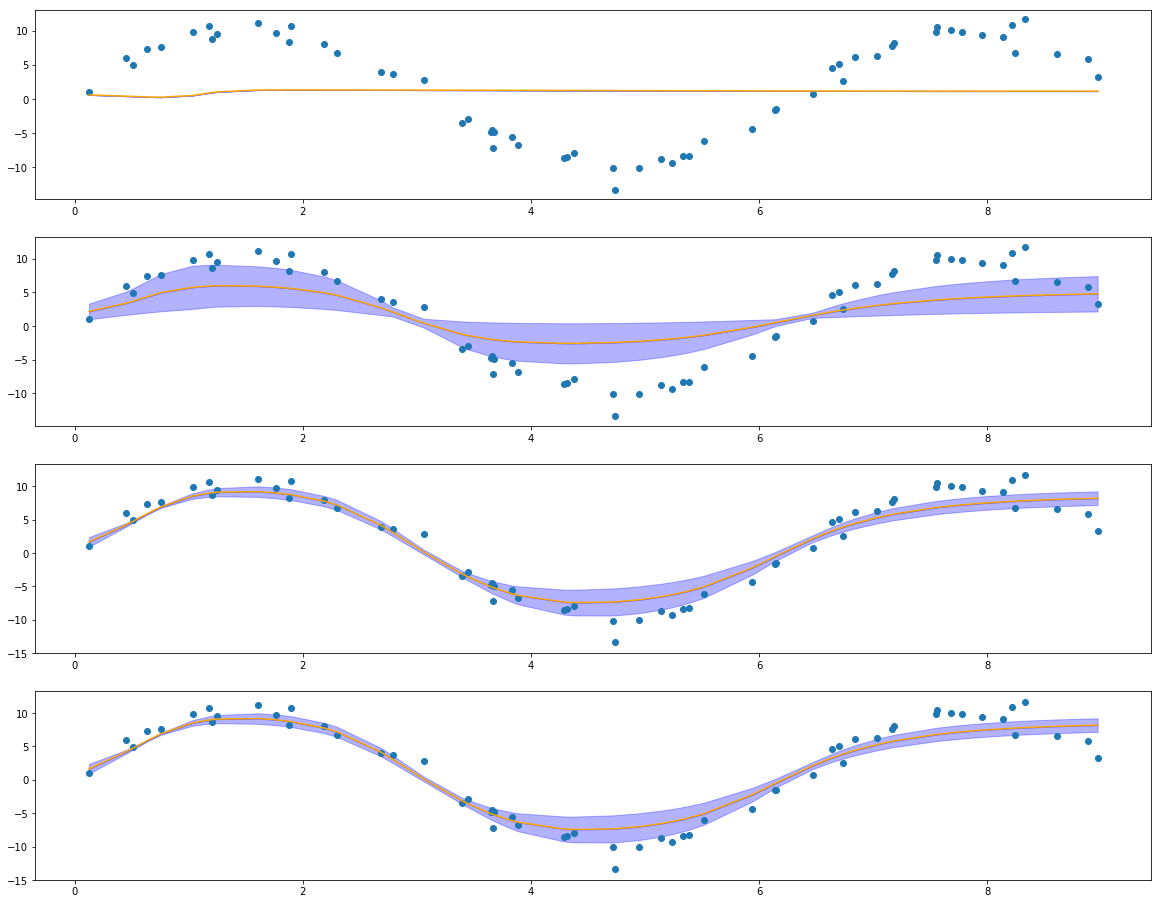

In [72]:
riker  = BootstrapThroughTimeBobStrap()

visualisation.visualise_uncertainty(riker,dataset_creation.NonlinearDataset)